In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [63]:
dat = pd.read_csv('semi_cleaned.csv')
# lets replace NaN's in the a_body column (there are 2) with empty strings
dat.a_body = dat.a_body.replace(np.nan, '', regex=True)

In [64]:
def remove_lines_start_with(message, start_with):
    # Removes lines starting with anything in the list start_with in a message where lines are specified with \n
    split_message = message.split('\n')
    include_lines = [ x for x in split_message if not any([x.startswith(y) for y in start_with])]
    cleaned_message = '\n'.join(include_lines)
    
    return cleaned_message

In [65]:
def remove_after_symbols(message, symbols):
    # Removes all content after the apperence of any of the substrings present in symbols.
    # For end of emails usually use symbols = ['--', '__'] or similar.
    
    # If a substring isn't in a string find returns -1 and so we need to filter those ones out.
    appearence_indexs = [message.find(x) for x in symbols if message.find(x) != -1]
    
    # appearence_indexs may be empty so just check for that
    if appearence_indexs:
        return message[0:min(appearence_indexs)]
    else:
        return message

In [66]:
body_lengths = dat.a_body.apply(len)

In [67]:
print('Median Message Length: {}'.format(body_lengths.median()))

Median Message Length: 1129.0


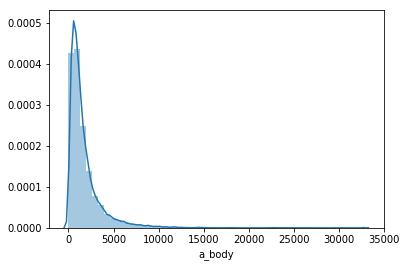

In [68]:
sns.distplot(body_lengths)
plt.show()

In [69]:
def cleaner(message):
    after_symbols = ['--', '__', '**', ' From:', 'From:', 'Von:']
    line_symbols = ['>', '_>']
    return remove_lines_start_with(
        remove_after_symbols(message, after_symbols),
        line_symbols
    )
    

In [70]:
cleaned_messages = dat.a_body.apply(cleaner)

In [71]:
cleaned_body_lengths= cleaned_messages.apply(len)

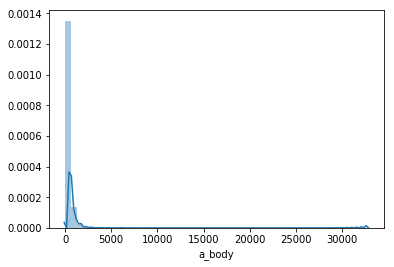

In [72]:
sns.distplot(cleaned_body_lengths)
plt.show()

In [73]:
# Remove all messages of length >= 2000
retained_data_lengths = cleaned_body_lengths[cleaned_body_lengths < 2000]
print('Removed {0} enteries, {1} of the data retained, Total Tickets Remaining: {2}'.format(
    len(cleaned_body_lengths) - len(retained_data_lengths),
    len(retained_data_lengths)/len(cleaned_body_lengths),
    len(retained_data_lengths)
))

Removed 149 enteries, 0.9919184249064381 of the data retained, Total Tickets Remaining: 18288


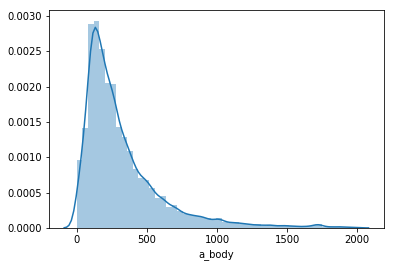

In [74]:
sns.distplot(cleaned_body_lengths[cleaned_body_lengths < 2000])
plt.show()

In [75]:
print('Median Cleaned Message Length: {}'.format(retained_data_lengths.median()))

Median Cleaned Message Length: 233.0


In [76]:
# Now do the process on the dataframe
dat['a_body_clean'] = dat.a_body.apply(cleaner)
selected_dat = dat[dat.a_body_clean.apply(len) < 2000]

In [77]:
print(selected_dat.a_body_clean[17989])


Das Studiensekretariat ist infolge Krankheit zur Zeit nicht besetzt.

Die Mails werden nicht gelesen oder beanwortet

Freundliche Grüsse V. Gloor

   


In [78]:
# Time for translation
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="google_cloud_cred/DataScienceLab-0f7dd55a59ec.json"

from google.cloud import translate

# Instantiates a client
translate_client = translate.Client(target_language='en')

In [80]:
# Going to send things to the API in chunks of length 100 messages
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

In [84]:
list_of_clean_messages = list(selected_dat.a_body_clean)
translation_results = []
list_of_chunks = list(chunks(list_of_clean_messages, 100))

# Each chunk has ~ <40000 (upper bound) (real max is 43735, median 31628)
# Total Chr count: 5,894,049
# Can send 1,000,000,000 per day and 100,000 per 100 seconds which means we wait 50 seconds per chunk 
# (it should be 40 but then it does the third chunk after 80 seconds and you get a limit, so 2 in 100 seconds is
# the best we can do).
# Total count of chunks is 183 which means 2.5 hours total.
time_to_wait = 0

for chunk_index, small_chunk in enumerate(list_of_chunks):
    # Request from API
    print('Translating Chunk #{0}. Size: {1}'.format(chunk_index, sum([len(x) for x in small_chunk])))
    small_chunk_translated = translate_client.translate(small_chunk)
    translation_results.extend(small_chunk_translated)
    print('Translated, waiting...')
    
    time.sleep(time_to_wait)
    
langs = [x['detectedSourceLanguage'] for x in translation_results]
translations = [x['translatedText'] for x in translation_results]
selected_dat['lang'] = langs
selected_dat['translation'] = translations

Translating Chunk #0. Size: 37111
Translated, waiting...
Translating Chunk #1. Size: 30383
Translated, waiting...
Translating Chunk #2. Size: 36581
Translated, waiting...
Translating Chunk #3. Size: 29910
Translated, waiting...
Translating Chunk #4. Size: 31279
Translated, waiting...
Translating Chunk #5. Size: 32706
Translated, waiting...
Translating Chunk #6. Size: 30555
Translated, waiting...
Translating Chunk #7. Size: 34708
Translated, waiting...
Translating Chunk #8. Size: 28156
Translated, waiting...
Translating Chunk #9. Size: 31733
Translated, waiting...
Translating Chunk #10. Size: 26382
Translated, waiting...
Translating Chunk #11. Size: 38109
Translated, waiting...
Translating Chunk #12. Size: 35264
Translated, waiting...
Translating Chunk #13. Size: 34923
Translated, waiting...
Translating Chunk #14. Size: 41439
Translated, waiting...
Translating Chunk #15. Size: 30745
Translated, waiting...
Translating Chunk #16. Size: 32156
Translated, waiting...
Translating Chunk #17. S

Translated, waiting...
Translating Chunk #142. Size: 40978
Translated, waiting...
Translating Chunk #143. Size: 32452
Translated, waiting...
Translating Chunk #144. Size: 32208
Translated, waiting...
Translating Chunk #145. Size: 31156
Translated, waiting...
Translating Chunk #146. Size: 37754
Translated, waiting...
Translating Chunk #147. Size: 32426
Translated, waiting...
Translating Chunk #148. Size: 30052
Translated, waiting...
Translating Chunk #149. Size: 30000
Translated, waiting...
Translating Chunk #150. Size: 35866
Translated, waiting...
Translating Chunk #151. Size: 33275
Translated, waiting...
Translating Chunk #152. Size: 36768
Translated, waiting...
Translating Chunk #153. Size: 38347
Translated, waiting...
Translating Chunk #154. Size: 30038
Translated, waiting...
Translating Chunk #155. Size: 37228
Translated, waiting...
Translating Chunk #156. Size: 26426
Translated, waiting...
Translating Chunk #157. Size: 30030
Translated, waiting...
Translating Chunk #158. Size: 339

/Users/brianregan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/brianregan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [85]:
selected_dat.to_csv('cleaned_translated.csv', index=False)

In [95]:
selected_dat.groupby(['lang'])['lang'].count()

lang
ar           1
co           3
cs           1
da           7
de       14498
el           1
en        3738
fi           2
fr           7
gd           3
haw          1
hi           1
hmn          1
id           1
it           1
ku           1
lb           8
no           3
pl           3
ro           1
sk           1
sl           1
tr           1
zh-CN        3
Name: lang, dtype: int64

In [131]:
print(selected_dat.translation[630])

Good morning Mr. Schwyter Unfortunately I could not reach her. We still have a problem with the email address [1] logistik@services.ethz.ch. Whenever we send an e-mail via this address, we will not find any e-mails in the Sent Items folder. Thank you very much. Best regards Rita Chalabi
